## Calculus

In [2]:
%matplotlib inline
import numpy as np
from matplotlib_inline import backend_inline
from d2l import torch as d2l

In [3]:
def f(x):
    return 3 * x ** 2 - 4 * x

**the *derivative* of $f$ at a point $x$ is defined as**
**$$f'(x) = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h}.$$**

In [4]:
for h in 10.0**np.arange(-1, -6, -1):
    print(f'h={h:.5f}, numerical limit={(f(1+h)-f(1))/h:.5f}')

h=0.10000, numerical limit=2.30000
h=0.01000, numerical limit=2.03000
h=0.00100, numerical limit=2.00300
h=0.00010, numerical limit=2.00030
h=0.00001, numerical limit=2.00003


In [5]:
def use_svg_display():  #@save
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

In [6]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [7]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [8]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""

    def has_one_axis(X):  # True if X (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    set_figsize(figsize)
    if axes is None:
        axes = d2l.plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

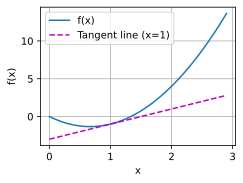

In [9]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

### Partial Derivative

$$ \frac{\partial y}{\partial x_i} = \lim_{h \rightarrow 0} \frac{f(x_1, \ldots, x_{i-1}, x_i+h, x_{i+1}, \ldots, x_n) - f(x_1, \ldots, x_i, \ldots, x_n)}{h}.$$

We can concatenate partial derivatives 
of a multivariate function 
with respect to all its variables 
to obtain a vector that is called
the *gradient* of the function.
Suppose that the input of function 
$f: \mathbb{R}^n \rightarrow \mathbb{R}$ 
is an $n$-dimensional vector 
$\mathbf{x} = [x_1, x_2, \ldots, x_n]^\top$ 
and the output is a scalar. 
The gradient of the function $f$ 
with respect to $\mathbf{x}$ 
is a vector of $n$ partial derivatives:

$$\nabla_{\mathbf{x}} f(\mathbf{x}) = \left[\partial_{x_1} f(\mathbf{x}), \partial_{x_2} f(\mathbf{x}), \ldots
\partial_{x_n} f(\mathbf{x})\right]^\top.$$ 


## Automatic Differentiation
- Most of the newer frameworks have automatic differentiation built in them, it is generally known as `Autograd`
- the gradient of a scalar-valued function with respect to a vector x is vector-valued with the same shape as x
- PyTorch does not automatically reset the gradient buffer when we record a new gradient. Instead, the new gradient is added to the already-stored gradient

In [10]:
import torch

In [14]:
x = torch.arange(4.0, requires_grad=True)
x, x.grad

(tensor([0., 1., 2., 3.], requires_grad=True), None)

In [16]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [17]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [18]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [19]:
# We can also detach some variables from the grad, these could be variables which we use for intermediate calculations
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

### Exercise
##### 1. Why is the second derivative much more expensive to compute than the first derivative?
Ans (bard): In autograd, the second derivative is computed by essentially backpropagating through the backpropagation process itself. This means you first perform backpropagation to compute the first derivative, and then you backpropagate again through that entire backpropagation graph to obtain the second derivative. This doubling of backpropagation steps significantly increases computational cost.

##### 2. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
Ans: The gradients are going to add up the more we call `backward()`. We need to set the grads to zero before calling the backward function again

In [32]:
x = torch.arange(4.0, requires_grad=True)
loss = 2 * torch.dot(x, x)

In [33]:
loss.backward(retain_graph=True)
print(x.grad)
loss.backward(retain_graph=True)
print(x.grad)

tensor([ 0.,  4.,  8., 12.])
tensor([ 0.,  8., 16., 24.])


##### 3. In the control flow example where we calculate the derivative of d with respect to a, what would happen if we changed the variable a to a random vector or a matrix? At this point, the result of the calculation f(a) is no longer a scalar. What happens to the result? How do we analyze this?
Ans: We can see that as `c` is not a scalar, we can not use `.backward()` on `d`. But if we retrun `c.sum()` we can actually start using it

In [46]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.arange(5.0, requires_grad=True)
print(a)
d = f(a)
d.backward()
a.grad

tensor([0., 1., 2., 3., 4.], requires_grad=True)


RuntimeError: grad can be implicitly created only for scalar outputs

In [47]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c.sum()

a = torch.arange(5.0, requires_grad=True)
print(a)
d = f(a)
d.backward()
a.grad

tensor([0., 1., 2., 3., 4.], requires_grad=True)


tensor([256., 256., 256., 256., 256.])

##### 4. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result. 

In [49]:
def f(x):
    return torch.sin(x)

x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 100, requires_grad=True)
y = f(x)

y.backward(torch.ones_like(x))

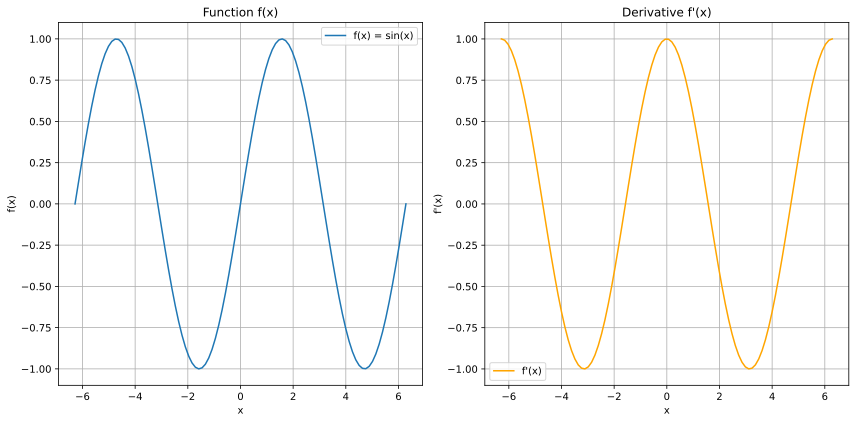

In [53]:
y_grad = x.grad
import matplotlib.pyplot as plt
x_np = x.detach().numpy()
y_np = y.detach().numpy()
y_grad_np = y_grad.detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plot f(x)
plt.subplot(1, 2, 1)
plt.plot(x_np, y_np, label="f(x) = sin(x)")
plt.title("Function f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()

# Plot f'(x)
plt.subplot(1, 2, 2)
plt.plot(x_np, y_grad_np, label="f'(x)", color='orange')
plt.title("Derivative f'(x)")
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()